In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import pytensor.tensor as pt
import matplotlib.pyplot as plt

az.style.use("arviz-darkgrid")

In [2]:
# Data preperation
df = pd.read_csv("MMM_test_data.csv")
df["start_of_week"] = pd.to_datetime(df["start_of_week"], format="%d-%m-%y")
n_channels = len(df.filter(like="spend").columns)
spend = df.filter(like="spend").values.astype('float32')
revenue = df["revenue"].values.astype('float32')
time_id = np.arange(len(spend), dtype="float32")

# Events
events = pd.to_datetime(["2020-11-29", "2021-01-24", "2021-11-28"])
df["event_1"] = (df["start_of_week"] == "2020-11-29").astype(int)  # 2020 Black Friday
df["event_2"] = (df["start_of_week"] == "2021-01-24").astype(int)  # 2021 Company promotion?
df["event_3"] = (df["start_of_week"] == "2021-01-31").astype(int)  # 2021 Company promotion?
df["event_4"] = (df["start_of_week"] == "2021-11-28").astype(int)  # 2021 Black Friday

avg_event_1 = df[df['start_of_week'] == '2020-11-29']['revenue'] * 0.3
avg_event_2 = df[df['start_of_week'] == '2021-01-24']['revenue'] * 0.4
avg_event_3 = df[df['start_of_week'] == '2021-01-31']['revenue'] * 0.4
avg_event_4 = df[df['start_of_week'] == '2021-11-28']['revenue'] * 0.3

# Binary classification for channel activity
channel_1_active = (spend[:, 0] > 0).astype('float32')
channel_6_active = (spend[:, 5] > 0).astype('float32')

In [3]:
def geometric_adstock(x, alpha: float = 0.0, l_max: int = 8):
    size = len(np.array(x))
    x = pt.as_tensor_variable(x)
    w = pt.power(alpha, pt.arange(l_max))[::-1]
    w /= pt.sum(w)
    padded = pt.concatenate([np.zeros(l_max - 1), x])
    window = pt.stack([padded[i:i + l_max] for i in range(size)])
    adstocked = pt.sum(w * window, axis=1)
    return adstocked

In [4]:
with pm.Model() as model:
    # Priors
    baseline = pm.Normal("baseline", mu=revenue.mean() * 0.5, sigma=revenue.std())  
    alpha = pm.Beta("alpha", alpha=2, beta=2, shape=n_channels)  # Retention with medium decay    
	
    beta = pm.HalfNormal("beta", sigma=5, shape=n_channels)  # Effectiveness
    #beta_inactive_1 = pm.Normal("beta_inactive_1", mu=0, sigma=5)  # Channel 1 inactive effect
    #beta_inactive_6 = pm.Normal("beta_inactive_6", mu=0, sigma=5)  # Channel 6 inactive effect

    # Seasonal priors
    sin_1 = pm.Normal("sin_1", mu=0, sigma=10)
    cos_1 = pm.Normal("cos_1", mu=0, sigma=10)
    sin_2 = pm.Normal("sin_2", mu=0, sigma=10)
    cos_2 = pm.Normal("cos_2", mu=0, sigma=10)

    freq1 = 2 * np.pi / 26  # Semi-annual
    freq2 = 2 * np.pi / 13  # Quarterly

    seasonality = (sin_1 * pt.sin(freq1 * time_id) + 
                   cos_1 * pt.cos(freq1 * time_id) +
                   sin_2 * pt.sin(freq2 * time_id) + 
                   cos_2 * pt.cos(freq2 * time_id))

    trend_coeff = pm.Normal("trend_coeff", mu=-1000, sigma=100)  # Trend based on prior observation
    sigma = pm.HalfNormal("sigma", sigma=10)  # Noise

    adstocked = pt.stack([
        geometric_adstock(spend[:, i], alpha[i], l_max=8)
        for i in range(n_channels)
    ], axis=1)    

    media = pt.dot(adstocked, beta)  # Media component
    trend = trend_coeff * time_id  # Trend component
    
    event_1_coeff = pm.Normal("event_1", mu=avg_event_1, sigma=1000) 
    event_2_coeff = pm.Normal("event_2", mu=avg_event_2, sigma=1000)
    event_3_coeff = pm.Normal("event_3", mu=avg_event_3, sigma=1000) 
    event_4_coeff = pm.Normal("event_4", mu=avg_event_4, sigma=1000)
    
    event_1 = event_1_coeff * df["event_1"].values
    event_2 = event_2_coeff * df["event_2"].values
    event_3 = event_3_coeff * df["event_3"].values
    event_4 = event_4_coeff * df["event_4"].values

    mu = baseline + media + trend + seasonality + event_1 + event_2 + event_3 + event_4 # Main equation

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=revenue)

    # Sample
    trace = pm.sample(8000, tune=2000, cores=4, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, alpha, beta, sin_1, cos_1, sin_2, cos_2, trend_coeff, sigma, event_1, event_2, event_3, event_4]


Output()

Sampling 4 chains for 2_000 tune and 8_000 draw iterations (8_000 + 32_000 draws total) took 107 seconds.


/home/emre/anaconda3/envs/pymc_env/lib/python3.12/site-packages/arviz/plots/traceplot.py:223: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (25), generating only 20 plots
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,94593.236,868.363,92996.189,96257.928,6.508,4.561,17809.0,22191.0,1.0
sin_1,10.377,10.025,-8.393,29.360,0.058,0.056,29659.0,23350.0,1.0
cos_1,0.559,9.979,-17.473,20.131,0.055,0.056,33502.0,24167.0,1.0
sin_2,-14.626,10.019,-34.162,3.650,0.052,0.056,37357.0,24625.0,1.0
cos_2,11.961,10.034,-7.230,30.370,0.055,0.055,33699.0,23938.0,1.0
trend_coeff,-749.154,12.382,-772.564,-725.977,0.099,0.069,15687.0,19750.0,1.0
event_1[0],149168.873,874.409,147535.778,150800.345,4.654,5.044,35328.0,24771.0,1.0
event_2[0],122685.202,860.639,121062.027,124302.966,4.583,4.759,35268.0,24846.0,1.0
event_3[0],89864.525,862.400,88310.937,91534.505,4.505,4.866,36645.0,25268.0,1.0
event_4[0],91141.249,881.749,89507.949,92806.234,4.691,4.993,35322.0,24417.0,1.0


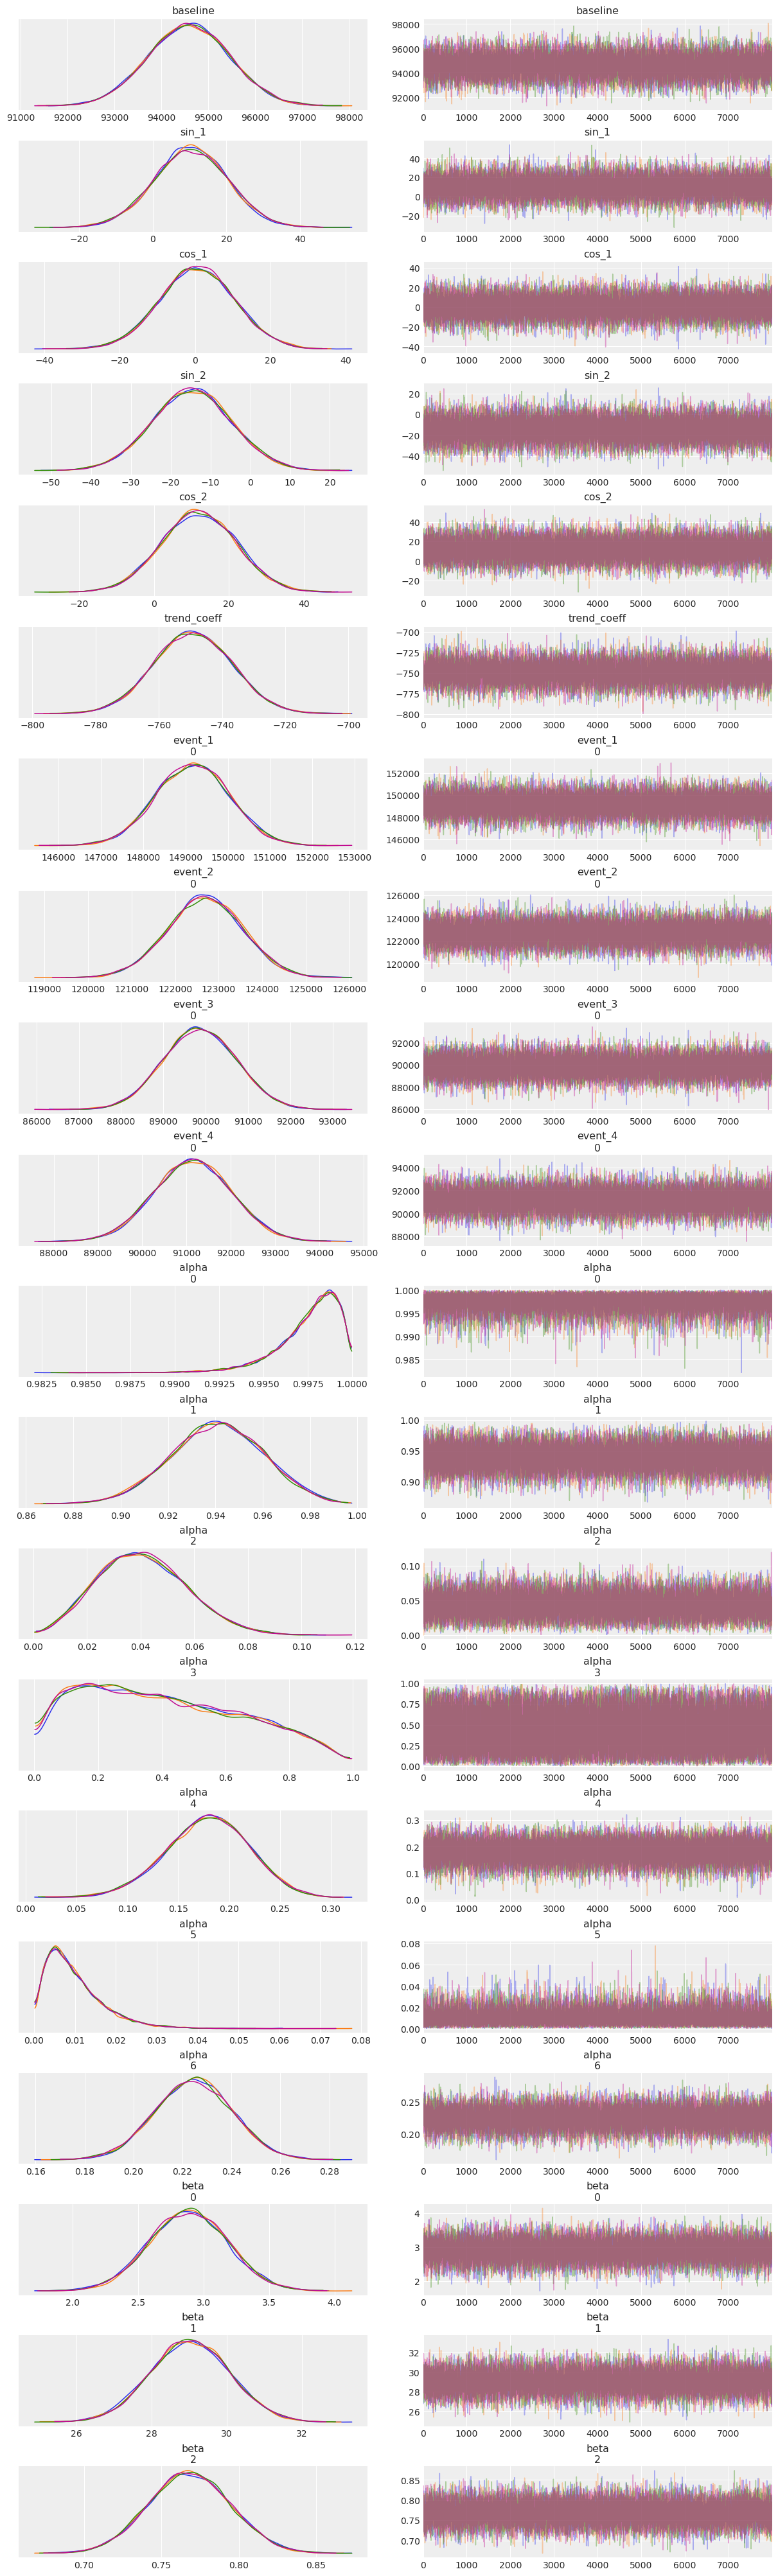

In [5]:
az.style.use("arviz-darkgrid")
az.plot_trace(trace, compact=False)
az.summary(trace)

Sampling: [y_obs]


Output()


Revenue Prediction Performance:
----------------------------------
MAPE: 16.44%
R²: 0.7352


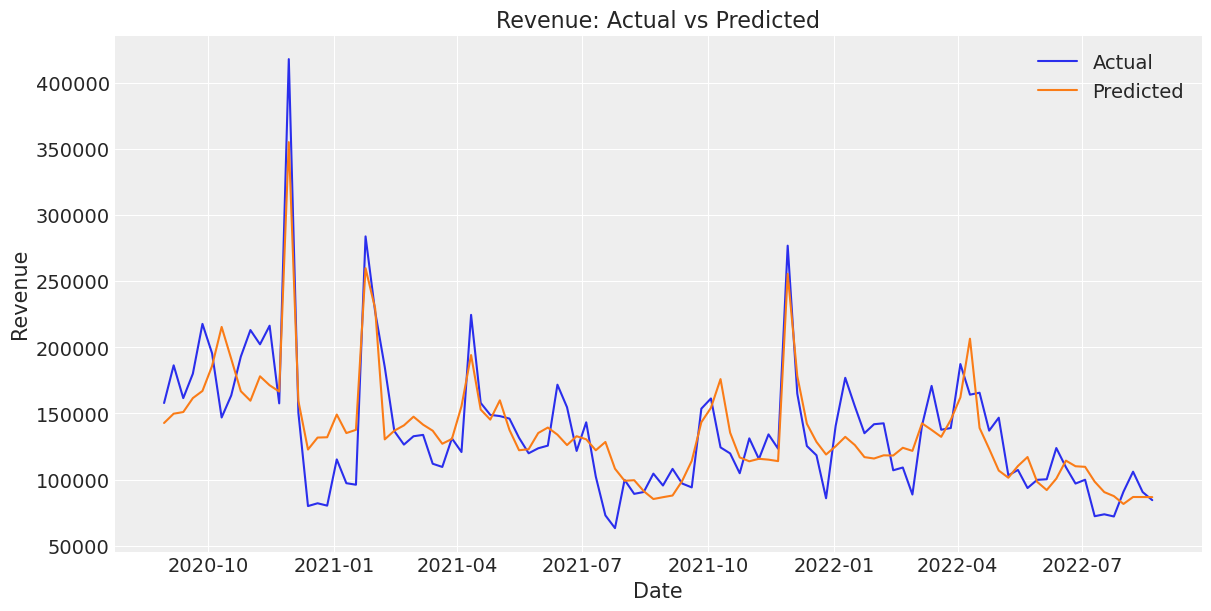

In [6]:
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=['y_obs'])

posterior_revenue = ppc.posterior_predictive['y_obs'].values.reshape(-1, len(df))

y_true = df['revenue'].values
y_pred = np.mean(posterior_revenue, axis=0)

# MAPE
mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100

# R^2
ss_res = np.sum((y_true - y_pred)**2)  # Residual sum of squares
ss_tot = np.sum((y_true - np.mean(y_true))**2)  # Total sum of squares
r2 = 1 - (ss_res/ss_tot)

print("\nRevenue Prediction Performance:")
print("----------------------------------")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# Optional: Basic plot
plt.figure(figsize=(12,6))
plt.plot(df['start_of_week'], y_true, label='Actual')
plt.plot(df['start_of_week'], y_pred, label='Predicted')
plt.legend()
plt.title("Revenue: Actual vs Predicted")
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.show()

In [7]:
with model:
    prior_samples = pm.sample_prior_predictive(samples=1000, var_names=['beta'])

prior_means = np.mean(prior_samples.prior['beta'].values.reshape(-1, n_channels), axis=0)
posterior_means = np.mean(trace.posterior['beta'].values.reshape(-1, n_channels), axis=0)

print("Channel  Prior Mean  Posterior Mean")
print("----------------------------------")
for i in range(n_channels):
    print(f"{i+1:^8} {prior_means[i]:.5f} {posterior_means[i]:.5f}")

Sampling: [beta]


Channel  Prior Mean  Posterior Mean
----------------------------------
   1     4.14128 2.88547
   2     4.08808 29.02609
   3     4.16706 0.76832
   4     3.97854 0.00620
   5     4.00471 0.56165
   6     3.92682 0.71285
   7     4.10606 1.43609


In [8]:
spend_cols = df.filter(like='spend').columns.tolist()
channel_spend = df[spend_cols].mean().values

# ROI = (Effect / Spend) * 100
roi_pct = (posterior_means / channel_spend) * 100

print("Channel   Spend    Effect    ROI(%)")
print("----------------------------------------")
for i in range(n_channels):
    print(f"{i+1:^7} ${channel_spend[i]:.2f}   {posterior_means[i]:.4f}   {roi_pct[i]:>.4f}%")

Channel   Spend    Effect    ROI(%)
----------------------------------------
   1    $1245.60   2.8855   0.2317%
   2    $343.64   29.0261   8.4466%
   3    $19507.18   0.7683   0.0039%
   4    $6915.14   0.0062   0.0001%
   5    $8575.61   0.5617   0.0065%
   6    $5063.70   0.7129   0.0141%
   7    $27701.37   1.4361   0.0052%
